<a href="https://colab.research.google.com/github/JinkyoHan/HermiNN/blob/main/HermiNN_Plane_Stress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Essentials
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from IPython.display import clear_output
import time
from sklearn.metrics import mean_squared_error, r2_score
from scipy.linalg import solve
from scipy.interpolate import interp1d
import random

In [2]:
# Seed 고정
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
torch.backends.cudnn.deterministic = True  # make sure cudnn is deterministic
torch.backends.cudnn.benchmark = False  # if benchmark=True, deterministic will be False


In [3]:
# Hermite Shape Function
class ShapeNet_hermit(nn.Module):
    def __init__(self):
        super(ShapeNet_hermit, self).__init__()

    def N1(self, x):
        return 1 - 3 * x**2 + 2 * x**3
    def N2(self, x):
        return x - 2 * x**2 + x**3
    def N3(self, x):
        return 3 * x**2 - 2 * x**3
    def N4(self, x):
        return - x**2 + x**3


    def forward(self, x, x_k_min_1, x_k, x_k_plu_1, is_first, is_last):
        relu = nn.ReLU()
        if is_first:
            right_x = (x_k_plu_1 - relu(x_k_plu_1 - x_k - relu(x-x_k)) - x_k) / (x_k_plu_1 - x_k)
            disp = self.N1(right_x)
            rot = self.N2(right_x)

        elif is_last:
            left_x = (x_k - relu(x_k - x_k_min_1 - relu(x-x_k_min_1)) - x_k_min_1) / (x_k - x_k_min_1)
            disp = self.N3(left_x)
            rot = self.N4(left_x)

        else:
            # Compute both terms
            left_x = (x_k - relu(x_k - x_k_min_1 - relu(x-x_k_min_1)) - x_k_min_1) / (x_k - x_k_min_1)
            right_x = (x_k_plu_1 - relu(x_k_plu_1 - x_k - relu(x-x_k)) - x_k) / (x_k_plu_1 - x_k)
            disp = (self.N1(right_x) + self.N3(left_x)) - 1
            rot = (self.N2(right_x) + self.N4(left_x)) / 2

        return disp, rot

# Hermite Elements
class HiNet_hermit(nn.Module):
    def __init__(self, starter=-1, final=1, steps=10, DBC_s='x', DBC_f='x', initial_value = 1.0):
        super(HiNet_hermit, self).__init__()
        self.shape_function = ShapeNet_hermit()
        self.steps = steps
        self.x_k_values = torch.linspace(starter, final, steps=self.steps, dtype=torch.float32)
        self.x_k_min_1_values = torch.cat([torch.tensor([0.0]), self.x_k_values[:-1]])
        self.x_k_plu_1_values = torch.cat([self.x_k_values[1:], torch.tensor([0.0])])

        # Initialize trainable DOF parameters for each shape function
        self.fixes = 0
        self.s_s, self.s_f, self.f_s, self.f_f = 0,0,0,0
        if DBC_s == 's':
            self.s_s += 1
            self.fixes += 1
        elif DBC_s == 'f':
            self.s_f += 1
            self.fixes += 2
        if DBC_f == 's':
            self.f_s += 1
            self.fixes += 1
        elif DBC_f == 'f':
            self.f_f += 1
            self.fixes += 2

        num_params = 2 * self.steps - self.fixes
        if isinstance(initial_value, list):
            assert len(initial_value) == num_params, f"Initial value list length {len(initial_value)} does not match expected number of parameters {num_params}."
            self.dof_params = nn.Parameter(torch.tensor(initial_value, dtype=torch.float32))
        else:
            self.dof_params = nn.Parameter(torch.full((num_params,), initial_value))

    def forward(self, x):
        total_output = 0

        dof_counter = 0
        for i in range(self.steps):
            x_k_min_1 = self.x_k_min_1_values[i]
            x_k = self.x_k_values[i]
            x_k_plu_1 = self.x_k_plu_1_values[i]
            is_first = (i == 0)
            is_last = (i == len(self.x_k_values) - 1)
            disp, rot = self.shape_function(x, x_k_min_1, x_k, x_k_plu_1, is_first, is_last)

            if is_first:
                if self.s_s > 0:
                    disp = 0
                    total_output += self.dof_params[dof_counter] * rot
                    dof_counter += 1
                elif self.s_f > 0:
                    pass
                else:
                    total_output += self.dof_params[dof_counter] * disp
                    dof_counter += 1
                    total_output += self.dof_params[dof_counter] * rot
                    dof_counter += 1

            elif is_last:
                if self.f_s > 0:
                    total_output += self.dof_params[dof_counter] * rot
                    dof_counter += 1
                elif self.f_f > 0:
                    pass
                else:
                    total_output += self.dof_params[dof_counter] * disp
                    dof_counter += 1
                    total_output += self.dof_params[dof_counter] * rot
                    dof_counter += 1
            else:
                total_output += self.dof_params[dof_counter] * disp
                dof_counter += 1
                total_output += self.dof_params[dof_counter] * rot
                dof_counter += 1
            #print(f'{i}th total output: {total_output}')
        #print(dof_counter)
        return total_output

In [4]:
def train_data_grid(Nx, Ny):
    # Generate x and y coordinates
    x = np.linspace(-1, 1, Nx)
    y = np.linspace(-1, 1, Ny)

    # Use meshgrid to generate grid points
    X, Y = np.meshgrid(x, y)

    # Transform grid points into (N, 2) shape
    Xf = np.vstack([X.ravel(), Y.ravel()]).T

    # Convert to PyTorch tensor
    Xf = torch.tensor(Xf, dtype=torch.float32, requires_grad=True)

    return Xf

def train_data(Nf, seed=None):
    if seed is not None:
        np.random.seed(seed)

    Xf2 = np.random.rand(Nf, 2) * 2 - 1

    Xf2 = torch.tensor(Xf2, dtype=torch.float32, requires_grad=True)

    return Xf2

In [5]:
# 2nd order derivative
def Laplace_w(xy, w):
    dw_xy = torch.autograd.grad(w, xy, grad_outputs=torch.ones_like(w), create_graph=True, retain_graph=True)
    dw_x = dw_xy[0][:,0]
    dw_y = dw_xy[0][:,1]

    dw_x_xy = torch.autograd.grad(dw_x, xy, grad_outputs=torch.ones_like(dw_x), create_graph=True, retain_graph=True)
    dw_xx = dw_x_xy[0][:,0]
    dw_xy = dw_x_xy[0][:,1]

    dw_y_xy = torch.autograd.grad(dw_y, xy, grad_outputs=torch.ones_like(dw_y), create_graph=True, retain_graph=True)
    dw_yy = dw_y_xy[0][:,1]

    return dw_x, dw_y, dw_xx, dw_xy, dw_yy


def TPE_PlaneStress(xy, w):
    _, _, dw_xx, dw_xy, dw_yy = Laplace_w(xy, w)

    #U_b = D / 2 * ((dw_xx+dw_yy)**2 + 2*(1-mu)*(dw_xy**2 - dw_xx*dw_yy))
    U_b = D / 2 * ((dw_xx+dw_yy)**2)

    U_e = q*w

    #print(U_b.shape), print(U_e.shape)

    return torch.mean(U_b), torch.mean(U_e)


In [10]:
# Problem Statement for Plane Stress
a = 1.0       # m, half transverse length
b = 1.0       # m, half longitudinal length
h = 0.001   # m, thickness
q = 1.0      # N/m^2, body force
E = 206e9     # 10^9 N/m^2
mu = 0.3    # Poisson's ratio
D = E * (h**3) / (12*(1-mu**2))

# Sampling coordinate data
num_sample_points = 5000
data = train_data(num_sample_points)

# Initializing Network
n_segments = 4
net_x = HiNet_hermit(-1, 1, n_segments, 'f', 'f')
net_y = HiNet_hermit(-1, 1, n_segments, 'f', 'f')

# Define Displacement Field
def Net_w(x):
    output = net_x(x[:,0]) * net_y(x[:,1])
    output *= h
    return output

# Optimizer Settings
params = []
params += list(net_x.parameters()) + list(net_y.parameters())
optimizer = optim.LBFGS(params, lr=0.5, max_iter=10, history_size=5)
num_epochs = 10

seed = 42 # for random sampling data
start_time_ml = time.time()

for epoch in range(num_epochs):

    def closure():
        optimizer.zero_grad()
        w=Net_w(data)
        U, V = TPE_PlaneStress(data, w)
        loss = U - V
        loss.backward()
        return loss

    loss=optimizer.step(closure)

    data = train_data(num_sample_points, seed=42)
    seed += 1

    if (epoch + 1) % 1 == 0:
        print(f'epoch:{epoch + 1}, Total loss:{loss.item():.4e},')

end_time_ml = time.time()

# Arrange Trained Data
print(f'Time Consumed: {end_time_ml - start_time_ml:.4} seconds')

print('\n----------------------------------------------------------------')
print(f'Maximum Displacement: {max(Net_w(data).detach().numpy()):.4e}m')
print(f'Analytic Series Solution for Clamped Plate: {0.02016 * (q * a**4 /D):.4e}m')
print(f'Analytic Series Solution for S-S Plate: {0.0649984 * (q * a**4 /D):.4e}m')


epoch:1, Total loss:1.6241e-04,
epoch:2, Total loss:-1.1686e-04,
epoch:3, Total loss:-1.6063e-04,
epoch:4, Total loss:-1.6159e-04,
epoch:5, Total loss:-1.6159e-04,
epoch:6, Total loss:-1.6159e-04,
epoch:7, Total loss:-1.6159e-04,
epoch:8, Total loss:-1.6159e-04,
epoch:9, Total loss:-1.6159e-04,
epoch:10, Total loss:-1.6159e-04,
Time Consumed: 1.64 seconds

----------------------------------------------------------------
Maximum Displacement: 1.0598e-03m
Analytic Series Solution for Clamped Plate: 1.0687e-03m
Analytic Series Solution for S-S Plate: 3.4455e-03m


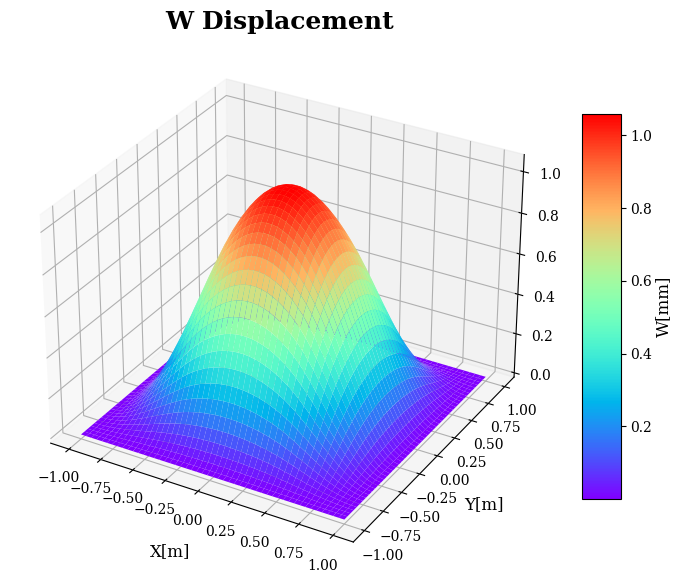

In [11]:
# Generate displacement fields
data = train_data_grid(50, 50)
w = Net_w(data).detach().numpy()

# Reshape data for plotting
x = data[:, 0].detach().numpy() * a
y = data[:, 1].detach().numpy() * b

# Create a meshgrid for plotting
X, Y = np.meshgrid(np.unique(x), np.unique(y))
W = w.reshape(X.shape)

# Setting font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Plotting the results
fig = plt.figure(figsize=(14, 8))

# Plot W displacement
ax3 = fig.add_subplot(121, projection='3d')
surf = ax3.plot_surface(X, Y, W*1000, cmap='rainbow')
ax3.set_title('W Displacement',fontsize=18,fontweight='bold')
ax3.set_xlabel('X[m]',fontsize=12,labelpad=10)
ax3.set_ylabel('Y[m]',fontsize=12,labelpad=10)


# colorbar
cbar = fig.colorbar(surf, ax=ax3, shrink=0.5, aspect=10)
cbar.set_label('W[mm]',fontsize=12, labelpad=2)
cbar.ax.xaxis.set_label_position('bottom')

plt.tight_layout()
plt.show()